In [1]:
import os
from os import walk

from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import itertools

import mne
from mne.datasets.sleep_physionet.age import fetch_data
from mne.time_frequency import psd_welch



from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay

from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [2]:
DATA_PATH = '/home/jovyan/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/'
mapping = {'EOG horizontal': 'eog',
       'Resp oro-nasal': 'misc',
       'EMG submental': 'misc',
       'Temp rectal': 'misc',
       'Event marker': 'misc'}


In [3]:
def read_raw_and_annotation_data(raw_data_name, annotation_name, should_plot=False):
    '''Returns a raw object and the annotation object.
    Input:
        - raw_data_name: string of raw_data file. Name endedd with PSG.edf.
        - annotation_name: string of annotation file. Name ended with Hypnogram.edf.
        - should_plot: plot the data if set to true for debug purpose.
    '''
    raw_train = mne.io.read_raw_edf(raw_data_name)
    annot_train = mne.read_annotations(annotation_name)

    raw_train.set_annotations(annot_train, emit_warning=False)
    raw_train.set_channel_types(mapping)

    # plot some data
    if should_plot:
        raw_train.plot(duration=60, scalings='auto')
    return raw_train, annot_train

In [4]:
def get_rawdata_annotation_filenames(dir):
    '''Returns a dict of all key: (raw_data, annotation) map assuming the first 7 characters are the same.
    '''
    file_pairs = {}
    for (dirpath, dirnames, filenames) in walk(dir):
        break       
    for file in filenames:
        key = file[:7]
        if key not in file_pairs:
            file_pairs[key] = ['', '']
        if file.endswith('Hypnogram.edf'):
            file_pairs[key][1] = file
        elif file.endswith('PSG.edf'):
            file_pairs[key][0] = file
    return file_pairs
        
    

In [5]:
file_pairs = get_rawdata_annotation_filenames(DATA_PATH)
for key, value in file_pairs.items():
    print(value)

['SC4342F0-PSG.edf', 'SC4342FA-Hypnogram.edf']
['SC4651E0-PSG.edf', 'SC4651EP-Hypnogram.edf']
['SC4472F0-PSG.edf', 'SC4472FA-Hypnogram.edf']
['SC4381F0-PSG.edf', 'SC4381FC-Hypnogram.edf']
['SC4421E0-PSG.edf', 'SC4421EA-Hypnogram.edf']
['SC4491G0-PSG.edf', 'SC4491GJ-Hypnogram.edf']
['SC4152E0-PSG.edf', 'SC4152EC-Hypnogram.edf']
['SC4631E0-PSG.edf', 'SC4631EM-Hypnogram.edf']
['SC4262F0-PSG.edf', 'SC4262FC-Hypnogram.edf']
['SC4602E0-PSG.edf', 'SC4602EJ-Hypnogram.edf']
['SC4621E0-PSG.edf', 'SC4621EV-Hypnogram.edf']
['SC4512E0-PSG.edf', 'SC4512EW-Hypnogram.edf']
['SC4712E0-PSG.edf', 'SC4712EA-Hypnogram.edf']
['SC4722E0-PSG.edf', 'SC4722EM-Hypnogram.edf']
['SC4642E0-PSG.edf', 'SC4642EP-Hypnogram.edf']
['SC4652E0-PSG.edf', 'SC4652EG-Hypnogram.edf']
['SC4112E0-PSG.edf', 'SC4112EC-Hypnogram.edf']
['SC4092E0-PSG.edf', 'SC4092EC-Hypnogram.edf']
['SC4322E0-PSG.edf', 'SC4322EC-Hypnogram.edf']
['SC4202E0-PSG.edf', 'SC4202EC-Hypnogram.edf']
['SC4501E0-PSG.edf', 'SC4501EW-Hypnogram.edf']
['SC4582G0-PS

Extracting EDF parameters from /home/jovyan/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4652E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


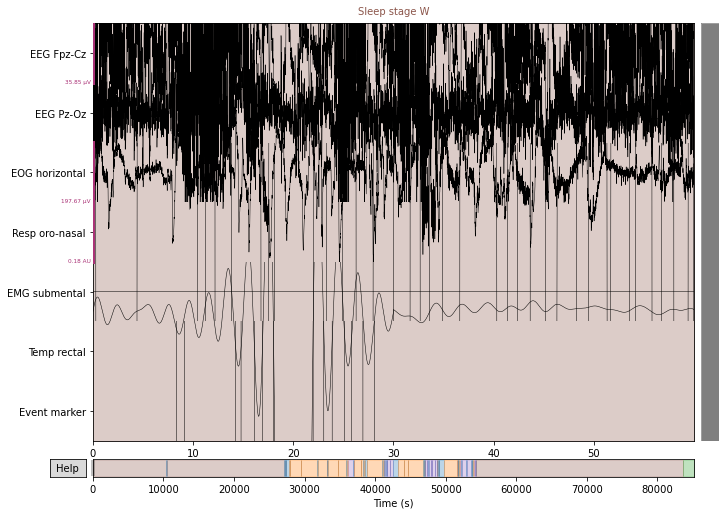

In [6]:
# Plot one pair of file
raw_train_example, annot_train_example = read_raw_and_annotation_data(os.path.join(DATA_PATH, 'SC4652E0-PSG.edf'), os.path.join(DATA_PATH, 'SC4342FA-Hypnogram.edf'), True)



In [34]:

print(raw_train_example[0][0].shape)
print(annot_train_example[0])

(1, 8520000)
OrderedDict([('onset', 0.0), ('duration', 10410.0), ('description', 'Sleep stage W'), ('orig_time', None)])


In [10]:
event_id = {'Sleep stage W': 1,
            'Sleep stage 1': 2,
            'Sleep stage 2': 3,
            'Sleep stage R': 5}
event_id_1 = {'Sleep stage W': 1,
              'Sleep stage 1': 2,
              'Sleep stage 2': 3,
              'Sleep stage R': 5}

In [11]:
def extract_events_plot(raw_train, annot_train, chunk_duration):
    events_train, _ = mne.events_from_annotations(
    raw_train, event_id=event_id, chunk_duration=chunk_duration)

    fig = mne.viz.plot_events(events_train, event_id=event_id_1,
                          sfreq=raw_train.info['sfreq'],
                          first_samp=events_train[0, 0])
    stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def extract_epochs(raw_data_name, annotation_name, chunk_duration):
    raw = mne.io.read_raw_edf(raw_data_name)
    annot = mne.read_annotations(annotation_name)
    annot.crop(annot[1]['onset'] - 30 * 60,
               annot[-2]['onset'] + 30 * 60)
    raw.set_annotations(annot, emit_warning=False)
    raw.set_channel_types(mapping)
    
    events, _ = mne.events_from_annotations(
    raw, event_id=event_id, chunk_duration=chunk_duration)
    tmax = 30. - 1. / raw.info['sfreq']  # tmax in included
    epochs = mne.Epochs(raw=raw, events=events,
                        event_id=event_id, tmin=0., tmax=tmax, baseline=None)
    return epochs
    

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage R', 'Sleep stage W']


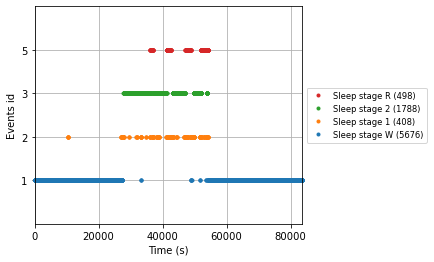

In [29]:
extract_events_plot(raw_train_example, annot_train_example, 10)

In [30]:
epochs_train = extract_epochs(os.path.join(DATA_PATH, 'SC4342F0-PSG.edf'), os.path.join(DATA_PATH, 'SC4342FA-Hypnogram.edf'), 10)
epochs_test = extract_epochs(os.path.join(DATA_PATH, 'SC4651E0-PSG.edf'), os.path.join(DATA_PATH, 'SC4651EP-Hypnogram.edf'), 10)

print(epochs_train)

print("==")

print(epochs_test)




Extracting EDF parameters from /home/jovyan/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4342F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
4746 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /home/jovyan/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4651E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
7512 matching events found
No baseline correction applied
0 projection items activated
<Epochs |  4746 events (good & bad), 0 - 29.99 sec, baseline off, ~18 kB, data not loaded,
 'Sleep stage 1': 408
 'Sleep stage 2': 1788
 'Sleep 

In [62]:
def save_eeg_power_band(epochs, prefix):
    """EEG relative power band feature extraction.

    This function takes an ``mne.Epochs`` object and creates EEG features based
    on relative power in specific frequency bands that are compatible with
    scikit-learn.

    Parameters
    ----------
    epochs : Epochs: The data.
    prefix : prefix to save the data file

    Returns
    -------
    X : numpy array of shape [n_samples, 5]
        Transformed data.
    """
    # specific frequency bands
    FREQ_BANDS = {"delta": [0.0, 4.0],
                  "theta": [4.0, 8.0],
                  "alpha": [8.0, 13],
                  "beta": [13, 22],
                  "gamma": [30, 100]}

    psds, freqs = psd_welch(epochs, picks='eeg', fmin=0.5, fmax=100.)
    # Normalize the PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X_mean = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)]
        psds_band_mean = psds_band.mean(axis=-1)
        psds_band_max = psds_band.max(axis=-1)
        psds_band_min = psds_band.min(axis=-1)
        psds_half_mmd = psds_band_max - psds_band_min
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X_mean.append(psds_band.reshape(len(psds), -1))
        X_mean.append(psds_half_mmd.reshape(len(psds), -1))
    features = np.concatenate(X_mean, axis=1)
    columns = []
    for i in range(5):
        columns.append('mean{}0'.format(i))
        columns.append('mean{}1'.format(i))
        columns.append('mmd{}0'.format(i))
        columns.append('mmd{}1'.format(i))
    df = pd.DataFrame(data=features, columns=columns)
    df['label'] = epochs.events[:, 2]
    df.to_parquet('./parquet_data/{}_features.parquet'.format(prefix))
    return df
    

In [63]:

df = save_eeg_power_band(epochs_train, 'test')

Loading data for 4746 events and 3000 original time points ...
Effective window size : 2.560 (s)


In [64]:
df.head()

,mean00,mean01,mmd00,mmd01,mean10,mean11,mmd10,mmd11,mean20,mean21,...,mmd21,mean30,mean31,mmd30,mmd31,mean40,mean41,mmd40,mmd41,label
0,0.099871,0.038080,0.244544,0.097030,0.006451,0.006735,0.013249,0.005432,0.001072,0.004526,...,0.007181,0.000293,0.003307,0.000750,0.003812,0.000225,0.007079,0.000422,0.025219,1
1,0.096457,0.031157,0.215642,0.093705,0.008664,0.006154,0.018932,0.005747,0.001420,0.005689,...,0.009851,0.000340,0.003268,0.000901,0.004125,0.000266,0.008165,0.000569,0.027534,1
2,0.095544,0.024458,0.269323,0.061288,0.009084,0.006140,0.017855,0.003385,0.001428,0.005580,...,0.009556,0.000369,0.003282,0.000865,0.003407,0.000321,0.009193,0.000713,0.034060,1
3,0.101604,0.022024,0.530641,0.080817,0.005490,0.006113,0.013348,0.005171,0.000912,0.005625,...,0.006913,0.000208,0.003412,0.000274,0.004445,0.000191,0.009508,0.000413,0.034571,1
4,0.101893,0.023256,0.410991,0.063293,0.005433,0.006731,0.011701,0.006583,0.000879,0.005030,...,0.005757,0.000196,0.003784,0.000274,0.004146,0.000174,0.009199,0.000278,0.033124,1


In [57]:
X.to_parquet('./feature_test0.parquet')

In [324]:
def data_split(file_map, seed=0, training_ratio=0.9, cv_fold=5):
    np.random.seed(seed)
    file_count = len(file_map)
    fold_size = int(len(file_map) * training_ratio / cv_fold)
    training_sets = [[] for _ in range(cv_fold)]
    test_sets = []
    for key, (v1, v2) in file_pairs.items():
        if not v1 or not v2:
            continue
        if np.random.random_sample() <= training_ratio:
            for training_fold in training_sets:
                if len(training_fold) < fold_size:
                    training_fold.append(key)
        else:
            test_sets.append(key)
    return training_sets, test_sets


In [325]:
training_sets, test_sets = data_split(file_pairs)
print(training_sets)
print(test_sets)
print(raw_data)
print((file_pairs['SC4342F']))

[['SC4342F', 'SC4651E', 'SC4472F', 'SC4381F', 'SC4421E', 'SC4491G', 'SC4152E', 'SC4631E', 'SC4602E', 'SC4621E', 'SC4512E', 'SC4712E', 'SC4642E', 'SC4652E', 'SC4112E', 'SC4092E', 'SC4322E', 'SC4202E', 'SC4582G', 'SC4632E', 'SC4191E', 'SC4232E', 'SC4182E', 'SC4072E', 'SC4752E', 'SC4311E', 'SC4252E'], ['SC4342F', 'SC4651E', 'SC4472F', 'SC4381F', 'SC4421E', 'SC4491G', 'SC4152E', 'SC4631E', 'SC4602E', 'SC4621E', 'SC4512E', 'SC4712E', 'SC4642E', 'SC4652E', 'SC4112E', 'SC4092E', 'SC4322E', 'SC4202E', 'SC4582G', 'SC4632E', 'SC4191E', 'SC4232E', 'SC4182E', 'SC4072E', 'SC4752E', 'SC4311E', 'SC4252E'], ['SC4342F', 'SC4651E', 'SC4472F', 'SC4381F', 'SC4421E', 'SC4491G', 'SC4152E', 'SC4631E', 'SC4602E', 'SC4621E', 'SC4512E', 'SC4712E', 'SC4642E', 'SC4652E', 'SC4112E', 'SC4092E', 'SC4322E', 'SC4202E', 'SC4582G', 'SC4632E', 'SC4191E', 'SC4232E', 'SC4182E', 'SC4072E', 'SC4752E', 'SC4311E', 'SC4252E'], ['SC4342F', 'SC4651E', 'SC4472F', 'SC4381F', 'SC4421E', 'SC4491G', 'SC4152E', 'SC4631E', 'SC4602E', 'S

In [406]:
model_name = 'knn2'
cv_fold = 2
training_sets, test_sets = data_split(file_pairs, seed=0, training_ratio=0.8, cv_fold=cv_fold)
# print("Training set \n", training_sets)
# print("Test set \n", test_sets)

##  RandomForestClassifier
# pipe = make_pipeline(FunctionTransformer(eeg_power_band, validate=False),
#                      RandomForestClassifier(n_estimators=100, random_state=42, max_depth=8))

# KNN
pipe = make_pipeline(FunctionTransformer(eeg_power_band, validate=False),
                     KNeighborsClassifier(n_neighbors=5))

left_out = cv_fold - 1
# Train with cross validation
for _ in range(cv_fold):
    # Train
    for i in range(cv_fold):
        if i == left_out:
            continue
        for key in training_sets[i]:
            epochs_train = extract_epochs(os.path.join(DATA_PATH, file_pairs[key][0]), os.path.join(DATA_PATH, file_pairs[key][1]), 30)
            pipe.fit(epochs_train, epochs_train.events[:, 2])
    cv_accs = []
    cv_roc_aucs = []
    for key in training_sets[left_out]:
        epochs_test = extract_epochs(os.path.join(DATA_PATH, file_pairs[key][0]), os.path.join(DATA_PATH, file_pairs[key][1]), 30)
        y_pred = pipe.predict(epochs_test)
        y_test = epochs_test.events[:, 2]
        acc = accuracy_score(y_test, y_pred)
        cv_accs.append(acc)
        
#         roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
#         cv_roc_aucs.append(roc_auc)
    print("CV accuracy score: {}".format(np.average(cv_accs)))
#     print("CV ROC AUC score: {}".format(np.average(cv_roc_aucs)))
    left_out -= 1
    
filename = 'saved_models/{}.sav'.format(model_name)
pickle.dump(pipe, open(filename, 'wb'))
        





Extracting EDF parameters from /home/jovyan/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4342F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
1582 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1582 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Extracting EDF parameters from /home/jovyan/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4651E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
2504 matching events found
No baseline correction applied
0 projection items activated
Loading data for 2504 even

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
1169 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1169 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Extracting EDF parameters from /home/jovyan/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4632E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
1079 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1079 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Extracting EDF parameter

Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
999 matching events found
No baseline correction applied
0 projection items activated
Loading data for 999 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Extracting EDF parameters from /home/jovyan/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4031E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
895 matching events found
No baseline correction applied
0 projection items activated
Loading data for 895 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Extracting EDF parameters from /home/jovyan/ph

Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
1104 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1104 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Extracting EDF parameters from /home/jovyan/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4012E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
1090 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1090 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Extracting EDF parameters from /home/jovyan/physionet.org/files/sleep-edfx/1

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
1013 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1013 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Extracting EDF parameters from /home/jovyan/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4342F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
1582 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1582 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Extracting EDF parameters from /home/jovyan/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4651E0-PS

Not setting metadata
Not setting metadata
1020 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1020 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Extracting EDF parameters from /home/jovyan/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4582G0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
1169 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1169 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Extracting EDF parameters from /home/jovyan/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4632E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Ann

Not setting metadata
1529 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1529 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Extracting EDF parameters from /home/jovyan/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4551F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
999 matching events found
No baseline correction applied
0 projection items activated
Loading data for 999 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Extracting EDF parameters from /home/jovyan/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4031E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: 

1791 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1791 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Extracting EDF parameters from /home/jovyan/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4441E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
1104 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1104 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Extracting EDF parameters from /home/jovyan/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4012E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', '

No baseline correction applied
0 projection items activated
Loading data for 1542 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Extracting EDF parameters from /home/jovyan/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4492G0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
1013 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1013 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
CV accuracy score: 0.6205108057696734
Extracting EDF parameters from /home/jovyan/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4342F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep 

691 matching events found
No baseline correction applied
0 projection items activated
Loading data for 691 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Extracting EDF parameters from /home/jovyan/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4322E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
1020 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1020 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Extracting EDF parameters from /home/jovyan/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4582G0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sl

No baseline correction applied
0 projection items activated
Loading data for 784 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Extracting EDF parameters from /home/jovyan/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4211E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
1529 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1529 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Extracting EDF parameters from /home/jovyan/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4551F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage

0 projection items activated
Loading data for 1986 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Extracting EDF parameters from /home/jovyan/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4482F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
1791 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1791 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Extracting EDF parameters from /home/jovyan/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4441E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage R', 'Sleep stage W']
Not sett

Loading data for 1676 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Extracting EDF parameters from /home/jovyan/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4821G0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
1542 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1542 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Extracting EDF parameters from /home/jovyan/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4492G0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting meta

0 bad epochs dropped
Effective window size : 2.560 (s)
Extracting EDF parameters from /home/jovyan/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4112E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
691 matching events found
No baseline correction applied
0 projection items activated
Loading data for 691 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Extracting EDF parameters from /home/jovyan/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4322E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
1020 matching events found
No baseline correction applied
0 

Effective window size : 2.560 (s)
Extracting EDF parameters from /home/jovyan/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4081E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
784 matching events found
No baseline correction applied
0 projection items activated
Loading data for 784 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Extracting EDF parameters from /home/jovyan/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4211E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
1529 matching events found
No baseline correction applied
0 projection items acti

Extracting EDF parameters from /home/jovyan/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4661E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
1986 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1986 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Extracting EDF parameters from /home/jovyan/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4482F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
1791 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1791 even

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
1676 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1676 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Extracting EDF parameters from /home/jovyan/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4821G0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
1542 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1542 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Extracting EDF parameter

In [407]:
loaded_model = pickle.load(open(filename, 'rb'))


In [408]:
def convert_to_onehot(array):
    n_values = np.max(array) + 1
    return np.eye(n_values)[array]

In [409]:
# Test

accs = []
cm_total = np.zeros((4, 4))
y_preds = []
y_tests = []
for i in range(len(test_sets)):
    key = test_sets[i]
    epochs_test = extract_epochs(os.path.join(DATA_PATH, file_pairs[key][0]), os.path.join(DATA_PATH, file_pairs[key][1]), 30)
    y_pred = pipe.predict(epochs_test)
    y_test = epochs_test.events[:, 2]
    acc = accuracy_score(y_test, y_pred)
    accs.append(acc)
    cm = confusion_matrix(y_test, y_pred)
    cm_total += cm
    y_preds.extend(y_pred.tolist())
    y_tests.extend(y_test.tolist())


print(accs)
print("Test accuracy score: {}".format(np.average(accs)))
print("Confusion matrix\n")
print(cm_total)

Extracting EDF parameters from /home/jovyan/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4631E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
1024 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1024 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Extracting EDF parameters from /home/jovyan/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4262F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
901 matching events found
No baseline correction applied
0 projection items activated
Loading data for 901 events

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
899 matching events found
No baseline correction applied
0 projection items activated
Loading data for 899 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Extracting EDF parameters from /home/jovyan/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
998 matching events found
No baseline correction applied
0 projection items activated
Loading data for 998 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Extracting EDF parameters fr

In [410]:
def plot_roc_auc(y_preds, y_tests, model_name=""):
    plt.figure()
    y_preds_oh = convert_to_onehot(y_preds)
    y_tests_oh = convert_to_onehot(y_tests)
    print(y_preds_oh)
    colors = ['', 'aqua', 'darkorange', 'cornflowerblue','', 'deeppink']
    labels = ['', 'Sleep stage W', 'Sleep stage 1', 'Sleep stage 2', '', 'Sleep stage R']
    for c in [1, 2, 3, 5]:
        fpr, tpr, _ = roc_curve(y_tests_oh[:, c], y_preds_oh[:, c])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC of class {labels[c]} = {roc_auc:0.2f})", color = colors[c])
    plt.legend(loc="lower right")
#     plt.show()
    plt.savefig("./plots/" + model_name + "_auc.png")
    

[[0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]]


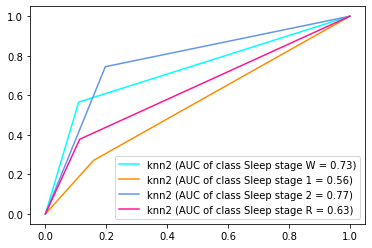

In [411]:
y_preds_oh = convert_to_onehot(y_preds)
# y_tests_oh = convert_to_onehot(y_tests)
# print(y_preds)
# print(y_preds_oh[50:100, :])
plot_roc_auc(y_preds, y_tests, model_name)

In [412]:
def plot_confusion_matrix(cm, class_names, model_name):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(i, j, "{:.2f}".format(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig("./plots/{}_cm.png".format(model_name))

[[0.56569208 0.23019985 0.06985566 0.13425241]
 [0.18628177 0.27091044 0.33752776 0.20528004]
 [0.10727368 0.08095986 0.74471107 0.06705539]
 [0.0513971  0.21068733 0.36018764 0.37772792]]


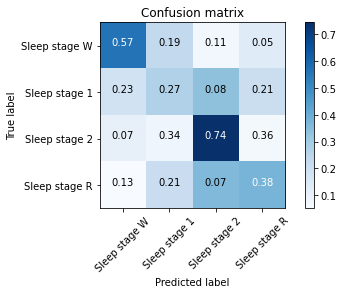

In [413]:

plot_confusion_matrix(cm_total, ['Sleep stage W', 'Sleep stage 1', 'Sleep stage 2', 'Sleep stage R'], model_name)
